# Human Body Dimension Estimation (HBDE) from occluded images

### Authors: M. Beiwinkler, M. Krimpelstätter, I. Viertola and T. Wulz

In [1]:
IN_HOSTED_COLAB_RUNTIME = 1
if IN_HOSTED_COLAB_RUNTIME == 1:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob
import random
from skimage.io import imread
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, LeakyReLU
from torch.optim import SGD

import tqdm
from sklearn.model_selection import KFold

%matplotlib inline

In [3]:
# Paths
if IN_HOSTED_COLAB_RUNTIME == 1:
    base = "/content/drive/MyDrive/data"  # Configure this variable accordingly where your dataset is in Google Drive
    TRAIN_TEST_PATH = os.path.join(base, "train_test_split.json")
else:
    base = os.getcwd()
    TRAIN_TEST_PATH = os.path.join(base, os.path.join("dataset", os.path.join("train_test", "train_test_split.json")))

DATASET_PATH = os.path.join(base, "dataset")
IMS_PATH = os.path.join(DATASET_PATH, os.path.join("synthetic_images", "200x200"))
ANNOS_PATH = os.path.join(DATASET_PATH, "annotations")

FULL_DATA_NP_ARRAY_PATH = os.path.join(base, "im_data.npy")
FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH = os.path.join(base, "im_data_with_occlusions.npy")
CHOSEN_ANNOS_NP_ARRAY_PATH = os.path.join(base, "im_annos.npy")

MODEL_SAVE_PATH = os.path.join(base, "model.pth")

if not os.path.exists(IMS_PATH):
    Exception("Dataset does not exist {}".format(DATASET_PATH))

## Data preparation

In [4]:
# Train/test split by img indices
f = open(TRAIN_TEST_PATH, "r")
train_test_split = json.load(f)
f.close()

# Load data from file or from the dataset
if os.path.exists(FULL_DATA_NP_ARRAY_PATH):
    im_data = np.load(FULL_DATA_NP_ARRAY_PATH)

else:
    im_data = []
    for fn in sorted(glob.glob(os.path.join(IMS_PATH, os.path.join("**", "*.png")), recursive=True)):
        img = imread(fn)
        img = img.astype('float32')
        img /= 255.0
        im_data.append(img)

    im_data = np.array(im_data)
    with open(FULL_DATA_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_data.shape == (12000, 200, 200):
    Exception("Problems with image data.")

# Load annotations. One subject has 2 images (12000 images in total) -> 6000 annotations (1 annotation per subject).
if os.path.exists(CHOSEN_ANNOS_NP_ARRAY_PATH):
    im_annos = np.load(CHOSEN_ANNOS_NP_ARRAY_PATH)

else:
    im_annos = []
    for anno_fn in sorted(glob.glob(os.path.join(ANNOS_PATH, os.path.join("*", "*.json")))):
        f = open(anno_fn, "r")
        annotations = json.load(f)
        im_annos.append([annotations['human_dimensions']['height'], annotations['human_dimensions']['shoulder_width'],
                            annotations['human_dimensions']['left_arm_length'], annotations['human_dimensions']['right_arm_length'],
                            annotations['human_dimensions']['pelvis_circumference'], annotations['human_dimensions']['chest_circumference']])
    im_annos = np.array(im_annos)
    with open(CHOSEN_ANNOS_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_annos.shape == (6000, 6):
    Exception("Problems with image annotations.")

# Prepare occluded images

In [5]:
# Load occluded images from file or generate them

# Number of occluding rectangles per image. If you change this value, don't forget
# to delete any occluded images from disk before running this cell. This way you
# force new images with the appropriate number of occluding rectangles to be created.
# A value of zero leads to a value of one, two or three being chosen randomly for each image.
NUM_RECTANGLES = 1

if os.path.exists(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH):
    im_data_occl = np.load(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH)
else:
    # Seed pseudo-random number generator for reproducibility
    random.seed(a="HBDE from occluded images", version=2)

    # Add rectangles to images
    num_rectangles = NUM_RECTANGLES
    im_data_occl = []
    for img_index in range(im_data.shape[0]):
        # Convert from NumPy array to instance of Pillow Image class
        img = Image.fromarray(im_data[img_index])
        # Create an object that can be used to draw in the given image
        draw = ImageDraw.Draw(img)

        if NUM_RECTANGLES == 0:
            num_rectangles = random.randrange(1, 4)
        for rect in range(num_rectangles):
            # Determine position, length and width of occluding rectangle
            if img_index < 3000: # female in pose 0
                upper_left_x = random.randrange(30, 150)
                upper_left_y = random.randrange(30, 150)
            elif img_index < 6000: # male in pose 0
                upper_left_x = random.randrange(15, 170)
                upper_left_y = random.randrange(20, 175)
            elif img_index < 9000: # female in pose 1
                upper_left_x = random.randrange(65, 115)
                upper_left_y = random.randrange(30, 150)
            else: # male in pose 1
                upper_left_x = random.randrange(60, 120)
                upper_left_y = random.randrange(20, 175)

            lower_right_x = upper_left_x + random.randrange(10, 50)
            lower_right_y = upper_left_y + random.randrange(10, 50)

            # Draw rectangle
            draw.rectangle((upper_left_x, upper_left_y, lower_right_x, lower_right_y), fill="black")

        # Add manipulated image to list of occluded images
        im_data_occl.append(np.asarray(img))
        
    im_data_occl = np.array(im_data_occl)
    with open(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data_occl)
    f.close()

In [6]:
# Divide training and testing data
train_data = []
test_data = []
train_annos = []
test_annos = []

# FILL TRAIN/TEST DATA WITH OCCLUDED
for gender in train_test_split['train']:
    for pose in train_test_split['train'][gender]:
        for indices in train_test_split['train'][gender][pose]:
            train_data.append(np.take(im_data_occl, indices, axis=0))
            indices = indices - 6000 if indices > 5999 else indices
            train_annos.append(np.take(im_annos, indices, axis=0))

for gender in train_test_split['test']:
    for pose in train_test_split['test'][gender]:
        for indices in train_test_split['test'][gender][pose]:
            test_data.append(np.take(im_data_occl, indices, axis=0))
            indices = indices - 6000 if indices > 5999 else indices
            test_annos.append(np.take(im_annos, indices, axis=0))

train_data = np.array(train_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)
train_annos = np.array(train_annos, dtype=np.float32)
test_annos = np.array(test_annos, dtype=np.float32)

In [7]:
# Dataset class
class BodyImages(Dataset):
    def __init__(self, X, y, is_training) -> None:
        assert X.shape[0] == y.shape[0], "Sample amounts must match in X and y"
        self.X = X
        self.y = y
        self.is_training = is_training

        if torch.cuda.is_available(): 
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        super().__init__()
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.unsqueeze(torch.tensor(self.X[idx,:,:], requires_grad=True, device=self.device), 0), torch.tensor(self.y[idx, :], device=self.device)

## Create the CNN and define test function
Selected features (6): 
- height
- shoulder width
- right arm length
- left arm length
- pelvis circumifrence
- chest circumifrence


In [8]:
feature_amnt = 6
lin_ftr_amnt = 512

class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layers = Sequential(
            Conv2d(in_channels=1, out_channels=feature_amnt, kernel_size=5),
            LeakyReLU(inplace=True),
            BatchNorm2d(num_features=feature_amnt),
            MaxPool2d(kernel_size=5, stride=2),
            # Second convolutional layer
            Conv2d(in_channels=6, out_channels=(feature_amnt*2), kernel_size=5),
            LeakyReLU(inplace=True),
            MaxPool2d(kernel_size=5, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(in_features=23232, out_features=lin_ftr_amnt),
            LeakyReLU(inplace=True),
            Linear(in_features=lin_ftr_amnt, out_features=feature_amnt)
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = self.linear_layers(x)
        return x

def test(dataloader, model, loss_fn, results, fold):
    # Enable evaluation mode for model to disable any training-mode specific model behavior,
    # just in case our model behaves differently in training and eval mode
    # (not to be mistaken for a mechanism to disable gradient computation).
    model.eval()

    num_batches = len(dataloader)
    test_loss = 0

    i = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            results[fold, i:i+len(y), 0] = y.cpu().numpy()
            results[fold, i:i+len(pred), 1] = pred.cpu().numpy()
            test_loss += loss_fn(pred, y).item()
            i += len(y)

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

    return results

## Train the model

In [9]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# TODO: Now we only calculate MSE over all the 6 selected features.
#       Implement a model validation function where we calculate the MSE over specific feature.
#       This way we get a better idea how accurate our model really is for different HBDs.
def train(model, optim, loss_fn, dataloader):
    # Enable training mode for model to enable possible training-mode specific model behavior,
    # just in case our model behaves differently in training and eval mode.
    model.train()
    current_loss = 0.
    with tqdm.tqdm(dataloader, unit='batch') as b:
        for batch, (X, y) in enumerate(b):
            # Zero-out gradients
            optim.zero_grad()
            # Forward pass
            pred = model(X)
            # Compute loss
            loss = loss_fn(pred, y)
            # Backward pass and gradient computation
            loss.backward()
            # Parameter update
            optim.step()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

lr = 0.001
momentum = 0.9
batch_size = 100
epochs = 20
k_folds = 5

train_data_ds = BodyImages(train_data, train_annos, is_training=True)
test_data_ds = BodyImages(test_data, test_annos, is_training=False)
k_fold = KFold(n_splits=k_folds, shuffle=True)
dataset = ConcatDataset([train_data_ds, test_data_ds])
loss_fn = MSELoss()

results = np.empty((5, 2400, 2, 6))

if torch.cuda.is_available():
    device = torch.device('cuda')
    # network.cuda()
    loss_fn.cuda()
else:
    device = torch.device('cpu')
  
print("Using:", device, "\n")

# K-Fold cross validation model evaluation
for fold, (train_ids, test_ids) in enumerate(k_fold.split(dataset)):
    print(15 * "-" + "FOLD #{}".format(fold+1) + 15 * "-")

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)
    
    network = CNN()
    network.apply(reset_weights)
    optimizer = SGD(network.parameters(),lr=lr, momentum=momentum)

    if torch.cuda.is_available(): 
      device = torch.device('cuda')
      network.cuda()

    for e in range(epochs):
        print("-"*15, "epoch:", e + 1, "-"*15)
        train(network, optimizer, loss_fn, trainloader)

    torch.save(network.state_dict(), os.path.join(base, "model-{}-lr{}-mmnt{}.pth".format(fold+1, lr, momentum)))
    results = test(testloader, network, loss_fn, results, fold)

with open(os.path.join(base, "results-lr{}-mmnt{}.npy".format(lr, momentum)), "wb+") as f:
    np.save(f, results)
f.close()

Using: cuda 

---------------FOLD #1---------------
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=23232, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=6, bias=True)
--------------- epoch: 1 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 2 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 3 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 4 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 5 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 6 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 7 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 8 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 9 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 10 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 11 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.01batch/s]


--------------- epoch: 12 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 13 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 14 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 15 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 16 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 17 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 18 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 19 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 20 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


Avg loss: 0.001514 

---------------FOLD #2---------------
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=23232, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=6, bias=True)
--------------- epoch: 1 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 2 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 3 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 4 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 5 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 6 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 7 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 8 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 9 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 10 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 11 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 12 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 13 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 14 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 15 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 16 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 17 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 18 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 19 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 20 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.01batch/s]


Avg loss: 0.001252 

---------------FOLD #3---------------
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=23232, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=6, bias=True)
--------------- epoch: 1 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.05batch/s]


--------------- epoch: 2 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 3 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 4 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 5 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 6 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 7 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 8 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 9 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 10 ---------------


100%|██████████| 96/96 [00:16<00:00,  5.92batch/s]


--------------- epoch: 11 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 12 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 13 ---------------


100%|██████████| 96/96 [00:16<00:00,  5.99batch/s]


--------------- epoch: 14 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 15 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 16 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 17 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 18 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 19 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 20 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


Avg loss: 0.001212 

---------------FOLD #4---------------
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=23232, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=6, bias=True)
--------------- epoch: 1 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.05batch/s]


--------------- epoch: 2 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 3 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 4 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 5 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 6 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 7 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.01batch/s]


--------------- epoch: 8 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 9 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 10 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 11 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 12 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 13 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 14 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 15 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 16 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 17 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 18 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 19 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 20 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


Avg loss: 0.001482 

---------------FOLD #5---------------
Reset trainable parameters of layer = Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=23232, out_features=512, bias=True)
Reset trainable parameters of layer = Linear(in_features=512, out_features=6, bias=True)
--------------- epoch: 1 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.06batch/s]


--------------- epoch: 2 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 3 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 4 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 5 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 6 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 7 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 8 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 9 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 10 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 11 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.04batch/s]


--------------- epoch: 12 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 13 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


--------------- epoch: 14 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 15 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 16 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 17 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.00batch/s]


--------------- epoch: 18 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 19 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.03batch/s]


--------------- epoch: 20 ---------------


100%|██████████| 96/96 [00:15<00:00,  6.02batch/s]


Avg loss: 0.001037 



# Evaluation
k-fold cross validation with 5 folds. Each fold contains 2400 instances

In [10]:
accuracies_mad = []
for f in range(results.shape[0]):
    accuracies_mad.append(np.mean(np.absolute(results[f, :, 1, :] - results[f, :, 0, :]), axis=0))
print(accuracies_mad)
accuracies_mad_meanoverk = np.mean(accuracies_mad, axis=0)
print(accuracies_mad_meanoverk)

[array([0.03466666, 0.01993153, 0.02296275, 0.02191839, 0.03420214,
       0.04034444]), array([0.02966243, 0.02008993, 0.02141556, 0.02119806, 0.03065539,
       0.03759277]), array([0.03047086, 0.01886114, 0.02218849, 0.02135616, 0.02865839,
       0.03680945]), array([0.03153784, 0.02144978, 0.02227404, 0.02175825, 0.03335333,
       0.04166274]), array([0.02737756, 0.01714894, 0.01987214, 0.01958771, 0.02515134,
       0.03497761])]
[0.03074307 0.01949626 0.0217426  0.02116371 0.03040412 0.0382774 ]


In [11]:
accuracies_rpe = []
for f in range(results.shape[0]):
    accuracies_rpe.append(np.mean(np.absolute(np.divide(results[f, :, 1, :] - results[f, :, 0, :], results[f, :, 0, :])), axis=0))
print(accuracies_rpe)
accuracies_rpe_meanoverk = np.mean(accuracies_rpe, axis=0)
print(accuracies_rpe_meanoverk)

[array([0.02007599, 0.05319114, 0.04013677, 0.03788525, 0.0328872 ,
       0.03951437]), array([0.01722228, 0.09386383, 0.03741435, 0.0365904 , 0.02982798,
       0.03705237]), array([0.01776518, 0.05429974, 0.03883036, 0.0370416 , 0.02742088,
       0.03594315]), array([0.01835341, 0.09896759, 0.03908594, 0.03771037, 0.03244983,
       0.04105991]), array([0.01603241, 0.0459315 , 0.03485506, 0.03401575, 0.02392938,
       0.03441883])]
[0.01788985 0.06925076 0.0380645  0.03664868 0.02930306 0.03759772]


In [19]:
print("Estimation errors for occluded images:")
print("----- MAD")
print("  height: {:.3f} mm".format(accuracies_mad_meanoverk[0] * 1000))
print("  shoulder_width: {:.3f} mm".format(accuracies_mad_meanoverk[1] * 1000))
print("  left_arm_length: {:.3f} mm".format(accuracies_mad_meanoverk[2] * 1000))
print("  right_arm_length: {:.3f} mm".format(accuracies_mad_meanoverk[3] * 1000))
print("  pelvis_circumference: {:.3f} mm".format(accuracies_mad_meanoverk[4] * 1000))
print("  chest_circumference: {:.3f} mm".format(accuracies_mad_meanoverk[5] * 1000))
print()
print("----- RPE")
print("  height: {:.3f}%".format(accuracies_rpe_meanoverk[0]*100))
print("  shoulder_width: {:.3f}%".format(accuracies_rpe_meanoverk[1]*100))
print("  left_arm_length: {:.3f}%".format(accuracies_rpe_meanoverk[2]*100))
print("  right_arm_length: {:.3f}%".format(accuracies_rpe_meanoverk[3]*100))
print("  pelvis_circumference: {:.3f}%".format(accuracies_rpe_meanoverk[4]*100))
print("  chest_circumference: {:.3f}%".format(accuracies_rpe_meanoverk[5]*100))

Estimation errors for unoccluded images:
----- MAD
  height: 30.743 mm
  shoulder_width: 19.496 mm
  left_arm_length: 21.743 mm
  right_arm_length: 21.164 mm
  pelvis_circumference: 30.404 mm
  chest_circumference: 38.277 mm

----- RPE
  height: 1.789%
  shoulder_width: 6.925%
  left_arm_length: 3.806%
  right_arm_length: 3.665%
  pelvis_circumference: 2.930%
  chest_circumference: 3.760%


# Visualise results

In [44]:
example_im = np.array([np.take(im_data_occl, 9000, axis=0)])
example_ann = np.array([np.take(im_annos, 3000, axis=0)])

Avg loss: 0.001009 

Estimation errors for example image:
----- MAD
  height: 34.667 mm
  shoulder_width: 19.932 mm
  left_arm_length: 22.963 mm
  right_arm_length: 21.918 mm
  pelvis_circumference: 34.202 mm
  chest_circumference: 40.344 mm

----- RPE
  height: 2.008%
  shoulder_width: 5.319%
  left_arm_length: 4.014%
  right_arm_length: 3.789%
  pelvis_circumference: 3.289%
  chest_circumference: 3.951%


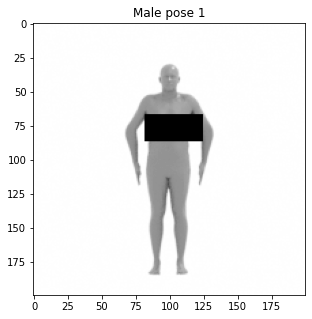

In [45]:
example_res = np.empty((1, 1, 2, 6))
example_dl = DataLoader(BodyImages(example_im, example_ann, is_training=False))
example_res = test(example_dl, network, loss_fn, example_res, 0)

plt.figure(figsize=(5, 5))
plt.imshow(example_im[0], cmap='gray'), plt.title("Male pose 1")

mad = np.mean(np.absolute(results[0, :, 1, :] - results[0, :, 0, :]), axis=0)
rpe = np.mean(np.absolute(np.divide(results[0, :, 1, :] - results[0, :, 0, :], results[0, :, 0, :])), axis=0)

print("Estimation errors for example image:")
print("----- MAD")
print("  height: {:.3f} mm".format(mad[0] * 1000))
print("  shoulder_width: {:.3f} mm".format(mad[1] * 1000))
print("  left_arm_length: {:.3f} mm".format(mad[2] * 1000))
print("  right_arm_length: {:.3f} mm".format(mad[3] * 1000))
print("  pelvis_circumference: {:.3f} mm".format(mad[4] * 1000))
print("  chest_circumference: {:.3f} mm".format(mad[5] * 1000))
print()
print("----- RPE")
print("  height: {:.3f}%".format(rpe[0]*100))
print("  shoulder_width: {:.3f}%".format(rpe[1]*100))
print("  left_arm_length: {:.3f}%".format(rpe[2]*100))
print("  right_arm_length: {:.3f}%".format(rpe[3]*100))
print("  pelvis_circumference: {:.3f}%".format(rpe[4]*100))
print("  chest_circumference: {:.3f}%".format(rpe[5]*100))